In [15]:
!git clone -b sam-unet --single-branch https://github.com/Rusteam/segmentation_models.pytorch.git
# !cd seg*
import os
os.chdir('segmentation_models.pytorch')

Cloning into 'segmentation_models.pytorch'...
remote: Enumerating objects: 1619, done.
remote: Counting objects: 100% (277/277), done.
remote: Compressing objects: 100% (135/135), done.
remote: Total 1619 (delta 155), reused 232 (delta 140), pack-reused 1342
Receiving objects: 100% (1619/1619), 5.07 MiB | 14.51 MiB/s, done.
Resolving deltas: 100% (953/953), done.


In [16]:
!ls
# !g
!pip install -e .

HALLOFFAME.md  README.md  examples  pyproject.toml		 setup.py
LICENSE        docker	  misc	    requirements.txt		 tests
MANIFEST.in    docs	  pics	    segmentation_models_pytorch
Obtaining file:///kaggle/working/segmentation_models.pytorch/segmentation_models_pytorch/segmentation_models.pytorch
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for segmentation-models-pytorch (pyproject.toml) ... done
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.3.2-0.editable-py3-none-any.whl size=9694 sha256=2193eb7863c85e246222446a51a29112181cce1fb16b1c7acd2f5f71e0fa08b0
  Stored in directory: /tmp/pip-ephem-wheel-cache-2rbw_vlk/wheels/ff/2a/22/85f3ca3615e951ab78fa999305bff99a12ed6266a0537c33a3
Successfully built segmentation-models-pytorch
  Attempting uninstall: segmentation-models

In [18]:
!pip install optuna

In [22]:
# importing libraries 
import os, sys
import numpy as np
import cv2
from PIL import Image
import pandas as pd 
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from IPython.display import clear_output
from albumentations import *

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torchvision.transforms import ToPILImage
from torch.utils.data.dataset import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

import segmentation_models_pytorch as smp
import time
import optuna

from os import listdir
from os.path import isfile, join
import csv
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("finished")

finished


In [23]:
def resize(path):
  dirs = os.listdir( path )
  for item in tqdm(dirs):
    if os.path.isfile(path+item):
      im = Image.open(path+item)
      f, e = os.path.splitext(path+item)
      imResize = im.resize((256,256), Image.NEAREST)
      imResize.save(f+e, 'PNG', quality=100)
      
features_path, label_path = "/kaggle/input/nucleus-data-c-elegans/nucleus_data/features", "/kaggle/input/nucleus-data-c-elegans/nucleus_data/segmentation_maps"
resize(label_path)
resize(features_path)

/tmp/ipykernel_27/1843803185.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for item in tqdm(dirs):


  0%|          | 0/6790 [00:00<?, ?it/s]

  0%|          | 0/6756 [00:00<?, ?it/s]

In [24]:
ids=[]
label_filenames = [f for f in listdir(label_path) if isfile(join(label_path, f))]
feature_filenames = [f for f in listdir(features_path) if isfile(join(features_path, f))]
for i in range(len(label_filenames)):
  ids.append(label_filenames[i][1:])
print(len(ids))

df = pd.DataFrame(ids ,columns=["file_ids"])
df.to_csv('file_ids.csv', index=False)

#sanity check
df = pd.read_csv('file_ids.csv')
df.head()

6790


,file_ids
0,59_8.png
1,47_29.png
2,138_11.png
3,94_6.png
4,57_4.png


In [25]:
class SegmentationDataset(Dataset):   
    def __init__(self, csv, augmentation =None, transform_image = None, transform_label = None):

        self.df = pd.read_csv(csv)
        self.ids  = self.df["file_ids"]
        self.transform_image = transform_image
        self.transform_label = transform_label
        self.augmentation = augmentation

    def __getitem__(self, idx):
        image= np.array(Image.open("/kaggle/input/nucleus-data-c-elegans/nucleus_data/features/F"+self.ids[idx]))
        mask=np.array(Image.open("/kaggle/input/nucleus-data-c-elegans/nucleus_data/segmentation_maps/L"+self.ids[idx]))
        if self.augmentation is not None:
                
            augmented  = self.augmentation(image = image, mask = mask)
            image = augmented["image"]
            mask = augmented["mask"]
       
        mask[mask != 0] = 1
        mask = self.transform_label(mask)
        mask = mask.float()
        return self.transform_image(image), mask
    
    def __len__(self):
        return len(self.ids)

In [26]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [27]:
full_dataset = SegmentationDataset(csv = "file_ids.csv",
                                    augmentation =  Compose([
                                                            #GridDistortion(p=0.5),
                                                            Transpose(p=0.5),
                                                            VerticalFlip(p=0.5),
                                                            HorizontalFlip(p=0.5),
                                                            RandomRotate90(p=0.5),
                                                            ShiftScaleRotate(p=0.1),
                                                            OpticalDistortion(distort_limit=0.3, shift_limit=0.3, p=1),
                                                            ]),

                                    transform_image = transforms.Compose([ 
                                                                    
                                                                    transforms.ToPILImage(),
                                                                    ToTensor(),
                                                                    transforms.RandomApply([AddGaussianNoise( mean = 0.5,std= 0.05)], p=0.5)
                                                                ]),                                  
                                    transform_label = transforms.Compose([ 
                                                                                                      
                                                                    transforms.ToPILImage(),
                                                                    ToTensor(),

                                                                ]))
     

In [28]:
train_batch_size = 32
train_size = int(0.8* len(full_dataset))  ## 80/20 split
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=test_dataset, batch_size= 4, shuffle = True)

print(len(train_loader), "batches ")
print(len(val_loader), " batches ")
sample = next(iter(train_loader))

340 batches 
340  batches 


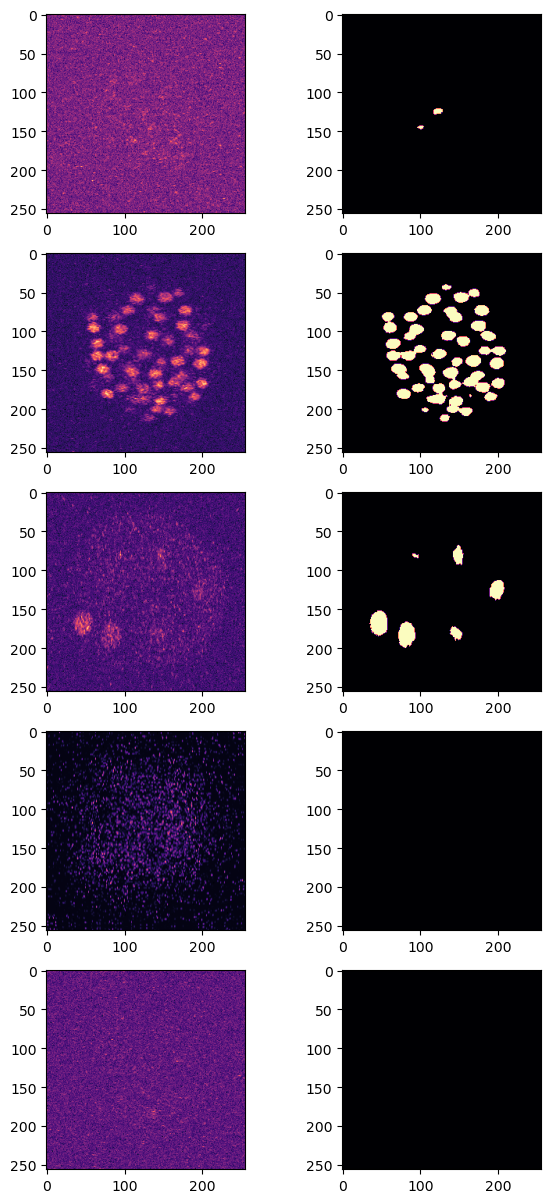

In [29]:
batch  = next(iter(train_loader))
images, masks = batch
fig, ax = plt.subplots(5, 2, figsize = (7,15))
for i in range(5):
    ax[i][0].imshow(images[i][0], cmap='magma')
    ax[i][1].imshow(masks[i][0], cmap='magma')

In [34]:
import segmentation_models_pytorch as smp

In [36]:
def plot_metrics(train_iou_scores, valid_iou_scores, val_dice_losses, lrs):

    plt.rcParams['figure.figsize'] = 15, 4
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    clear_output(wait = True)
    ax1.plot(train_iou_scores, color='blue', label='train')
    ax1.plot(valid_iou_scores, color='green', label='val')
    ax1.legend()
    ax1.grid()
    ax1.set_title('iou scores')
    ax2.plot(val_dice_losses, color = "green")
    ax2.grid()
    ax2.set_title('val dice loss')
    ax3.plot(lrs, color = "red")
    ax3.grid()
    ax3.set_title('learning rates')
    plt.show()


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

AttributeError: module 'segmentation_models_pytorch' has no attribute 'utils'

In [37]:
def run_training(epochs=2, lr=0.00015, batch_size=32, loss=loss, show_metrics=True, device='cuda', optuna=False):
    '''
    epochs: number of training epochs
    lr: learning rate
    batch_size: training batch size
    show metrics: to enable/disable plots
    device: choose b/w CPU and GPU based training
    optuna: Setting True will lead to loading only 10% of available data, for faster trials
    '''
    model = smp.SAM(
        encoder_name="sam-vit_b"
        encoder_weights="sa-1b",
        weights=None,
        image_size=64,
        decoder_multimask_output=decoder_multiclass_output,
        classes=n_classes,
    )

    optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=lr), 
    ])

    trainer = smp.utils.train.TrainEpoch(
        model, 
        loss=loss, 
        metrics=metrics, 
        optimizer=optimizer,
        device=device,
        verbose=show_metrics,
        )

    validator = smp.utils.train.ValidEpoch(
        model, 
        loss=loss, 
        metrics=metrics, 
        device=device,
        verbose=False,
    )
   
    scheduler = ReduceLROnPlateau(optimizer, 
                                    mode='min', 
                                    factor=0.2, 
                                    patience=11, 
                                    verbose=False, 
                                    threshold=0.0001, 
                                    threshold_mode='rel', 
                                    cooldown=0, 
                                    min_lr=0, 
                                    eps=1e-08)
    
    max_score = 0
    val_dice_losses, train_iou_scores, val_iou_scores, lrs = [],[],[],[]
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle = True, num_workers=2)

    if optuna:
      optuna_logs = trainer.run(val_loader)
      return(optuna_logs["iou_score"])

    for i in range(0, epochs):

        print('\nEpoch: {}'.format(i))

        train_logs = trainer.run(train_loader)
        valid_logs = validator.run(val_loader)
        val_dice_losses.append(valid_logs["dice_loss"]) 
        train_iou_scores.append(train_logs["iou_score"])
        val_iou_scores.append(valid_logs["iou_score"])
        scheduler.step(1.)
        lrs.append(get_lr(optimizer))

        if max_score < valid_logs['iou_score']:
            max_score = valid_logs['iou_score']
            torch.save(model, './best_model.pth')

        if show_metrics:
            plot_metrics(train_iou_scores, val_iou_scores, val_dice_losses, lrs)

    return(max_score)

NameError: name 'loss' is not defined